##  SavedFeaturesSelectedBackward20to2_CC**

In [501]:
 # TARGET VAR : 1: JND, 0 : GROUP, 2  CLUSTER
  
targetVar=1


#dti_metric choose 'FA','MD','RD' or 'AD'
dti_metric='AD'
CC=7
nFeatures=5
RandomState=0
nclust=2

#KNN
num_shuffles = 1000

#DECISION TREE
make_tree=0


make_jointplot=1


if targetVar==0:
    targetVarStr='Group'
elif targetVar==1:
    targetVarStr='JND'
elif targetVar==2:
    targetVarStr='Cluster'


In [502]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
import scipy.stats as scs
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
import matplotlib as ml
import mpl_toolkits.mplot3d 
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')


#list_of_selfeatures=np.load('SavedFeaturesSelectedBackwardAuto_CC'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)





if nFeatures=='auto':
    list_of_selfeatures=np.load('SavedFeaturesSelectedBackwardAuto_CC_'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)
else:
    list_of_selfeatures=np.load('SavedFeaturesSelectedBackward20to2_CC_'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)
    list_of_selfeatures=list_of_selfeatures[nFeatures]




SubjectTable= pd.read_csv('Subject_preproc.csv', sep=",")

dataRaw = pd.read_csv('CC_'+str(CC) +'_'+dti_metric+'.csv', sep=",")

SelectedFeat=(list_of_selfeatures)

## create 2 groups of JND below and above median of JND q=2

labels = [0,1]
SubjectTable['JND_group'] = pd.qcut(SubjectTable['JND_P'], q=2, labels=labels)

print(list_of_selfeatures)

data=pd.concat([dataRaw.loc[:,SelectedFeat], SubjectTable], axis=1)



Index(['75', '76', '77', '78', '79'], dtype='object')


## **KMEANS USING SavedFeaturesSelectedBackward_CC_X_Metrics**


In [503]:
dataCorrmat=data.drop(['sex','age','group_Y', 'group_O', 'JND_group', 'group'], axis=1)

cont=dataCorrmat.columns
corr_matrix=pd.DataFrame(dataCorrmat[cont],columns=cont).corr()


In [504]:




dataKmeans=data.drop(['sex','age','group_Y', 'group_O', 'JND_group', 'group','FA_body','MD_body','AD_body','RD_body','JND_P','IHD'], axis=1)

X=dataKmeans
dataKmeans.head()
data.columns
print(list_of_selfeatures)

#SCALING using a StandardScaler
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
Xscaled = pd.DataFrame(Xscaled, columns=X.columns)

Xscaled.head()

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

SilScore=[]
CalHar=[]
DavBouldin=[]
inertia=[]

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=RandomState).fit(Xscaled)
    SilScore.append(silhouette_score(Xscaled, kmeans.fit_predict(Xscaled)))
    CalHar.append(calinski_harabasz_score(Xscaled, kmeans.labels_))
    # DavBouldin.append(davies_bouldin_score(X, labels))
    inertia.append(kmeans.inertia_)  # Inertie (cohésion)

#AllSilScore.append(SilScore)
#AllCalHar.append(CalHar)
#Allinertia.append(inertia)

K_range = range(2, 10)  
    
df = pd.DataFrame({'Silhouette Score': SilScore,'Inertia': inertia,
               'Cal.-Har. Index': CalHar,'N Cluster': K_range})


#KMEANS  
nclust=2
kmeans = KMeans(n_clusters=nclust, random_state=RandomState).fit(Xscaled)
kmeans.labels_
CenterCluster=kmeans.cluster_centers_
labels_CC = kmeans.labels_

data["cluster"]=labels_CC


#f1='FA_body'
#f2='RD_body'
if CC==5:
    f1='54'
    f2='56'
elif CC==4:
    f1='26'
    f2='27'

f1=list_of_selfeatures[1]
f2=list_of_selfeatures[2]




Index(['75', '76', '77', '78', '79'], dtype='object')


### **HalvingGridSearchCV and DECISION TREE MANY ITERATION**

In [505]:
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, roc_auc_score)
from sklearn import tree
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

print(X.head())
print(Xscaled.head())

#X=dataKmeans
X=Xscaled

print(X.head())



if targetVar==0:
    Y_group=data["group"] 
    targetnames=['Y','O']
    y=Y_group
if targetVar==1:
    Y_group=data["JND_group"] 
    targetnames=['0','1']   
    y=Y_group
if targetVar==2:
    Y_group=labels_CC
    targetnames=['0','1']   
    y=data["cluster"] 


if make_tree==1:
        
    CVScore,AccuracyTree=[],[]

    for randstate in range(50):
        

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=randstate)
        
        param_grid = {'max_depth': [2,3,4 ,5, None],'splitter': ['best','random'],'criterion': ['gini', 'entropy'],"min_samples_split": [3,4,5]}
        
        # Initialize the DecisionTreeClassifier and GridSearchCV
        tree_clf = DecisionTreeClassifier(random_state=randstate)
        
        grid_search = HalvingGridSearchCV(tree_clf, param_grid,random_state=randstate,factor=3, cv=5).fit(X_train, y_train)
        
        # Fit the GridSearchCV to the training data
        grid_search.fit(X_train, y_train)
        
        # Get the best parameters and the best estimator
        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_
        
        # Evaluate the best estimator on the test data
        y_pred = best_estimator.predict(X_test)
        
        # Plot the best decision tree

        cm = confusion_matrix(y_test, y_pred)
            
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(best_estimator, X, y, cv=5)

        
        
        CVScore.append(np.mean(cv_scores))
        AccuracyTree.append(accuracy)

    print(f'mean CVScore: {np.mean(CVScore):.4f}')
    print(f'mean AccuracyTree: {np.mean(AccuracyTree):.4f}')

    ### **DECISION TREE LEARNING CURVE**

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Define the model
    #clf = DecisionTreeClassifier(random_state=42)

    # Generate the learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        best_estimator, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')


         75        76        77        78        79
0  0.001118  0.001117  0.001130  0.001139  0.001131
1  0.001300  0.001347  0.001366  0.001383  0.001402
2  0.001122  0.001119  0.001116  0.001112  0.001106
3  0.001194  0.001237  0.001262  0.001279  0.001286
4  0.001202  0.001194  0.001176  0.001154  0.001130
         75        76        77        78        79
0 -0.656816 -0.626308 -0.428199 -0.265738 -0.245227
1  1.124881  1.590127  1.778546  1.892299  2.061534
2 -0.619058 -0.602291 -0.557117 -0.504838 -0.450143
3  0.083644  0.532458  0.801858  0.970915  1.072544
4  0.165085  0.112942  0.000705 -0.134430 -0.247239
         75        76        77        78        79
0 -0.656816 -0.626308 -0.428199 -0.265738 -0.245227
1  1.124881  1.590127  1.778546  1.892299  2.061534
2 -0.619058 -0.602291 -0.557117 -0.504838 -0.450143
3  0.083644  0.532458  0.801858  0.970915  1.072544
4  0.165085  0.112942  0.000705 -0.134430 -0.247239


### **KNeighborsClassifier**

In [506]:
# KNN CLASSIFICATION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X=Xscaled


print(X.head())


if targetVar==0:
    Y_group=data["group"] 
    targetnames=['Y','O']
    y=Y_group
if targetVar==1:
    Y_group=data["JND_group"] 
    targetnames=['0','1']   
    y=Y_group
if targetVar==2:
    Y_group=labels_CC
    targetnames=['0','1']   
    y=data["cluster"] 
    

# Function to shuffle the dataset and evaluate the classifier
def evaluate_shuffled_data(X, y, n_neighbors, test_size, random_state,shuffle):

    if shuffle==1:
        random_state2=0
    elif shuffle==0:
        random_state2=random_state
    
    # Shuffle the dataset
    #X_shuffled, y_shuffled = X.sample(frac=1, random_state=random_state).values, y.sample(frac=1, random_state=0).values
    X_shuffled, y_shuffled = X.sample(frac=1, random_state=random_state).values, y.sample(frac=1, random_state=random_state2).values

    # Split the shuffled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=42)

    # Create and train the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = knn.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    score=knn.score(X_test, y_test, sample_weight=None)
    cm=confusion_matrix(y_test, y_pred)

    return accuracy,score,cm


accuracies_shuff = []
accuracies_real = []

score_shuff = []
score_real = []

cm_real = np.zeros((2,2))  
cm_shuff= np.zeros((2,2))   

for shuffle in [0,1]:
    
    # Number of shuffles to perform
    #num_shuffles = 2000  ## MOVED in the top section 
    
    # List to store the accuracies
    accuracies = []

    
    # Perform the shuffling and evaluation process multiple times
    for i in range(1,num_shuffles):
        accuracy,score,cm = evaluate_shuffled_data(X, y, n_neighbors=5, test_size=0.2, random_state=i,shuffle=shuffle)
        if shuffle==0:
            accuracies_real.append(accuracy)
            score_real.append(score)
            cm_real=cm_real+cm
            
        elif shuffle==1:
            accuracies_shuff.append(accuracy)
            score_shuff.append(score)
            cm_shuff=cm_shuff+cm
          
        accuracies.append(accuracy)

    # Convert the list of accuracies to a numpy array for analysis
    accuracies = np.array(accuracies)
    
    # Print the mean and standard deviation of the accuracies
    #print(f'Mean Accuracy: {accuracies.mean():.2f}')
    #print(f'Standard Deviation of Accuracy: {accuracies.std():.2f}')
    
    # Optionally, you can plot the distribution of accuracies
    




         75        76        77        78        79
0 -0.656816 -0.626308 -0.428199 -0.265738 -0.245227
1  1.124881  1.590127  1.778546  1.892299  2.061534
2 -0.619058 -0.602291 -0.557117 -0.504838 -0.450143
3  0.083644  0.532458  0.801858  0.970915  1.072544
4  0.165085  0.112942  0.000705 -0.134430 -0.247239


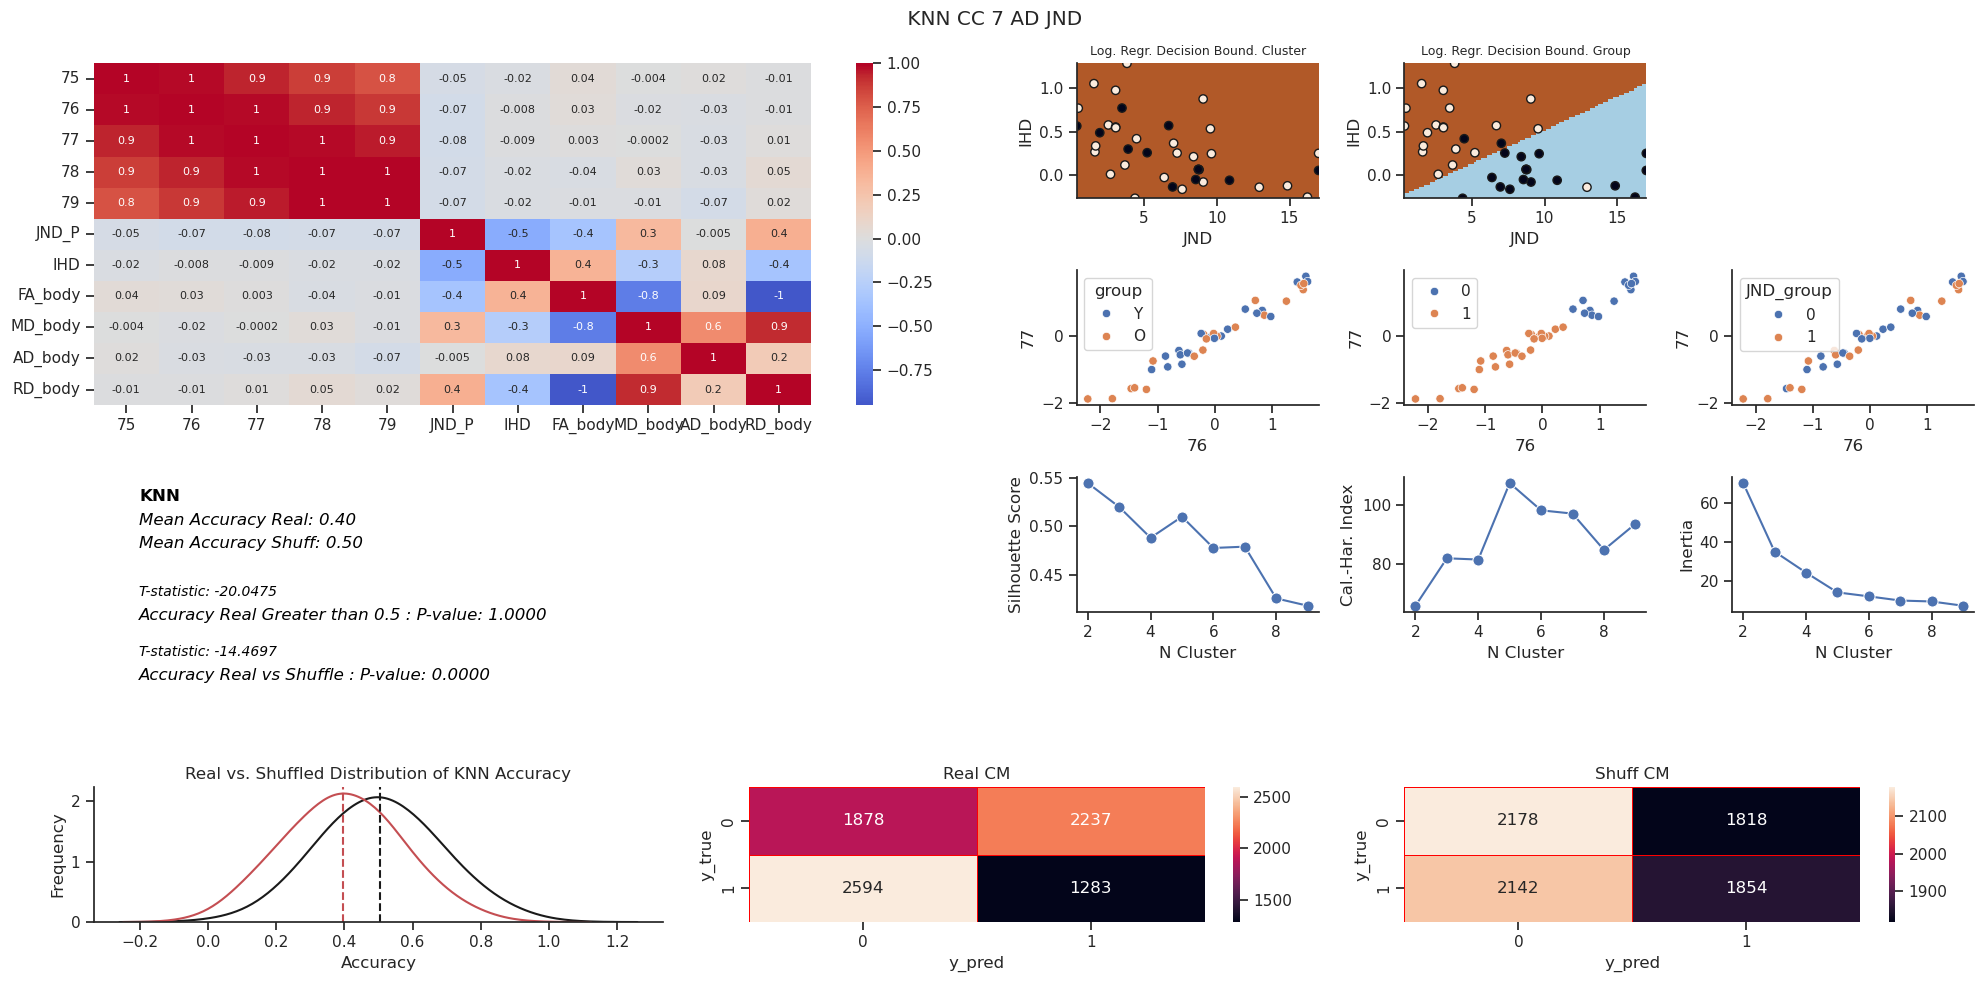

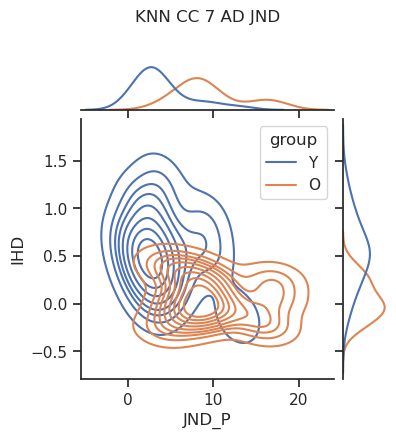

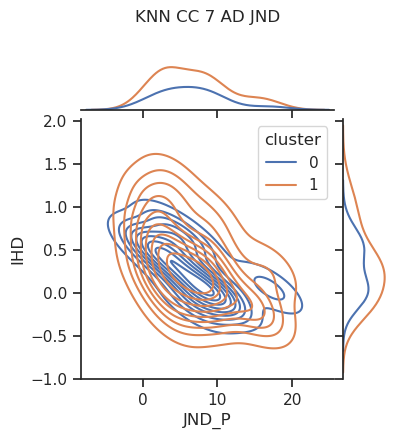

In [507]:
# PLOT CORRELATION MATRIX, CLUSTERS and LOGREG DECISION BOUNDARY

fig = plt.figure(tight_layout=True,figsize=(20,10))

gs = gridspec.GridSpec(9, 6)

ax = fig.add_subplot(gs[0:4,0:3])

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True, annot_kws={'size': 8},
            fmt='.1g',ax=ax)
fig.suptitle('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr)



# PLOT  CLUSTERS 

ax = fig.add_subplot(gs[4:6,3])

sns.lineplot(ax=ax,data=df, y='Silhouette Score', x='N Cluster', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[4:6,4])

sns.lineplot(ax=ax,data=df, x='N Cluster', y='Cal.-Har. Index', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[4:6,5])

sns.lineplot(ax=ax,data=df, x='N Cluster', y='Inertia', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)
fig.suptitle('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr)

ax = fig.add_subplot(gs[2:4,3])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=SubjectTable["group"]) 
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[2:4,4])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=labels_CC) 
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[2:4,5])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=SubjectTable["JND_group"]) 
ax.spines[['right', 'top']].set_visible(False)

import seaborn as sns

sns.set_theme(style="ticks")

SubjectTable["group"]
data.head()

SubjectTable["cluster"]=labels_CC


## PLOT DECISION BOUNDARY



from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

X = SubjectTable[['JND_P', 'IHD']]

subplotid=0    

for targetVarid in [0,2]:

    if targetVarid==2:
        y = SubjectTable['cluster']
        ax = fig.add_subplot(gs[0:2,3])
        ax.set_title('Log. Regr. Decision Bound. Cluster',fontsize=9)

    elif targetVarid==0:
        y = SubjectTable['group_Y']
        ax = fig.add_subplot(gs[0:2,4])
        ax.set_title('Log. Regr. Decision Bound. Group',fontsize=9)

    logreg = LogisticRegression(C=1e5)
    logreg.fit(X, y)
    DecisionBoundaryDisplay.from_estimator(logreg, X, cmap=plt.cm.Paired, ax=ax, response_method="predict", plot_method="pcolormesh", shading="auto",  xlabel="JND",  ylabel="IHD",  eps=0.5)
    ax.scatter(X['JND_P'], X['IHD'], c=y, edgecolors="k")
    ax.set_xlim(X['JND_P'].min(), X['JND_P'].max())
    ax.set_ylim(X['IHD'].min(), X['IHD'].max())
    ax.spines[['right', 'top']].set_visible(False)
    subplotid=subplotid+1

plt.suptitle(' KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr)




# PLOT RESULTS KNN

ax = fig.add_subplot(gs[7:9,0:2])

sns.kdeplot(data=accuracies_shuff, color='k', ax=ax,bw_adjust=2)
sns.kdeplot(data=accuracies_real, color='r', ax=ax,bw_adjust=2)

ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')
ax.set_title('Real vs. Shuffled Distribution of KNN Accuracy')

ax.spines[['right', 'top']].set_visible(False)

ax.axvline(x=np.mean(accuracies_shuff), color='k', linestyle='--')
ax.axvline(x=np.mean(accuracies_real), color='r', linestyle='--')


ax = fig.add_subplot(gs[7:9,2:4])


sns.heatmap(cm_real,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
ax.set_xlabel("y_pred")
ax.set_ylabel("y_true")
ax.set_title('Real CM')


ax = fig.add_subplot(gs[7:9,4:6])


sns.heatmap(cm_shuff,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
ax.set_xlabel("y_pred")
ax.set_ylabel("y_true")
ax.set_title('Shuff CM')

             
from scipy.stats import ttest_1samp,ttest_ind

t_statistic, p_value = ttest_1samp(accuracies_real, 0.5,alternative='greater')
t_statistic2, p_value2 = ttest_ind(accuracies_real, accuracies_shuff)

#print(f'Mean Accuracy Real: {np.mean(accuracies_real):.2f}')
#print(f'Mean Accuracy Shuff: {np.mean(accuracies_shuff):.2f}')


#print(f'T-statistic: {t_statistic:.4f}')
#print(f'Accuracy Real Greater than 0.5 : P-value: {p_value:.4f}')
#print(f'T-statistic: {t_statistic2:.4f}')
#print(f'Accuracy Real vs Shuffle : P-value: {p_value2:.4f}')


ax = fig.add_subplot(gs[4:7,0:3])


ax.set_axis_off()
Fontsize=12

ax.text(0.05, 0.9,r"$\bf{KNN  }$",   fontsize = Fontsize,     color = "black") 

ax.text(0.05, 0.8,f'Mean Accuracy Real: {np.mean(accuracies_real):.2f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 
ax.text(0.05, 0.7,f'Mean Accuracy Shuff: {np.mean(accuracies_shuff):.2f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 

ax.text(0.05, 0.5,f'T-statistic: {t_statistic:.4f}',  style = 'italic',     fontsize = 10,     color = "black") 
ax.text(0.05, 0.4,f'Accuracy Real Greater than 0.5 : P-value: {p_value:.4f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 
ax.text(0.05, 0.25,f'T-statistic: {t_statistic2:.4f}',  style = 'italic',     fontsize = 10,     color = "black") 
ax.text(0.05, 0.15,f'Accuracy Real vs Shuffle : P-value: {p_value2:.4f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 



namefig='KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr


plt.tight_layout()

plt.savefig(namefig,format='pdf')

plt.show()




if make_jointplot==1:



    grid1=sns.jointplot(x="JND_P", y="IHD", data=SubjectTable, hue="group", height=4,kind="kde")
    grid1.ax_joint.set_title('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr, pad=70)
    grid2=sns.jointplot(x="JND_P", y="IHD", data=SubjectTable, hue="cluster", height=4,kind="kde")
    grid2.ax_joint.set_title('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr, pad=70)


    plt.tight_layout()



